In [1]:
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from matplotlib import gridspec

/usr/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

In [3]:
master_data = pd.read_csv('crime-in-los-angeles/Crime_Data_2010_2017.csv')

In [4]:
master_data.columns

Index([u'DR Number', u'Date Reported', u'Date Occurred', u'Time Occurred',
       u'Area ID', u'Area Name', u'Reporting District', u'Crime Code',
       u'Crime Code Description', u'MO Codes', u'Victim Age', u'Victim Sex',
       u'Victim Descent', u'Premise Code', u'Premise Description',
       u'Weapon Used Code', u'Weapon Description', u'Status Code',
       u'Status Description', u'Crime Code 1', u'Crime Code 2',
       u'Crime Code 3', u'Crime Code 4', u'Address', u'Cross Street',
       u'Location '],
      dtype='object')

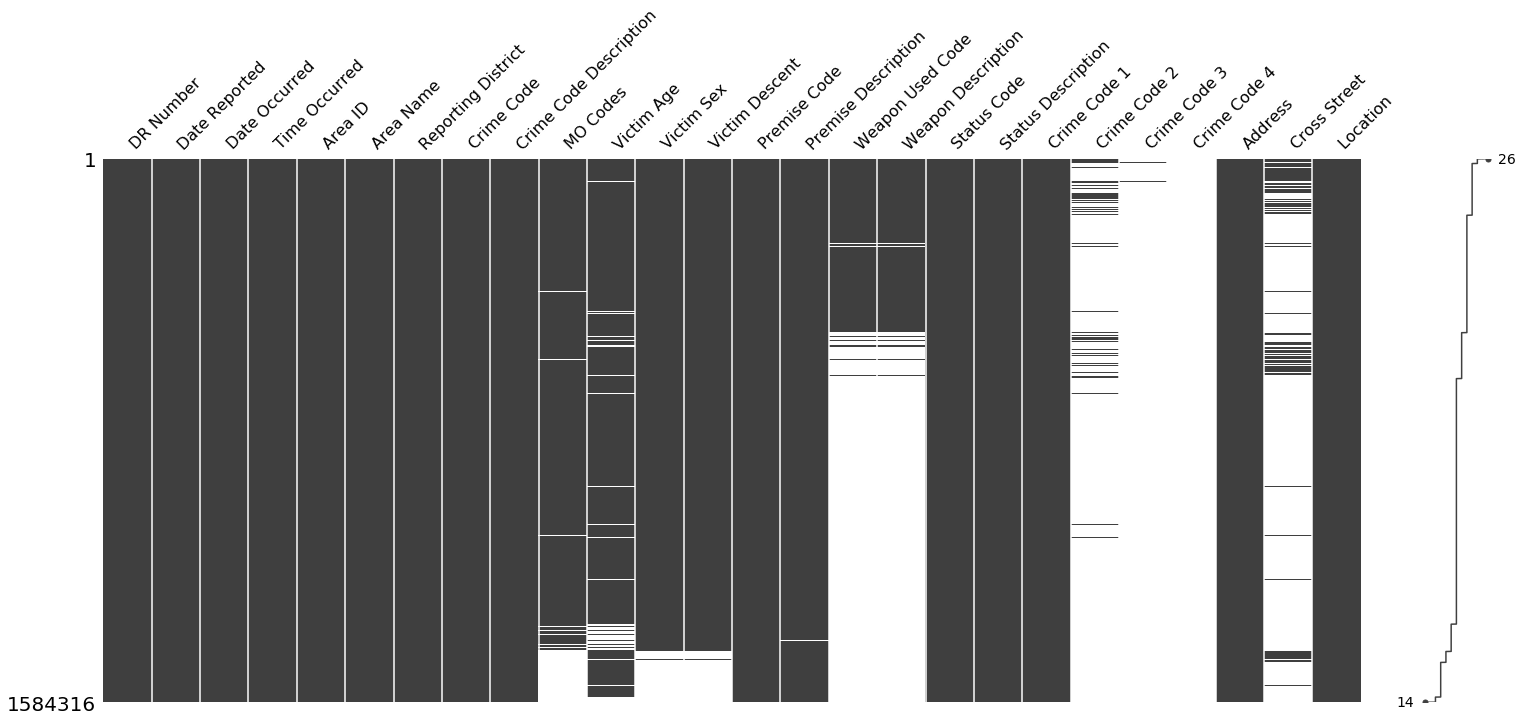

In [6]:
sorted_data = msno.nullity_sort(master_data, sort='descending')
msno.matrix(sorted_data)

## Quick Clean
We will break the location data to latitude and longitude. also convert the dat occurred data to pandas handy datetime type

In [6]:
master_data['Date Occurred'] = pd.to_datetime(master_data['Date Occurred'])
master_data['Time master_datarred'] = pd.to_datetime(master_data['Time Occurred'])

In [7]:
cols = master_data.columns[0:-1]
cols = cols.insert(len(cols), 'Location')
master_data.columns = cols

In [8]:
Location_X = []
Location_Y = []

for i in master_data['Location']:
    if(isinstance(i, str)):
        locs = i[1:-1].split(',')
        Location_X.append(float(locs[0]))
        Location_Y.append(float(locs[1][1:]))
    else:
        Location_X.append(0)
        Location_Y.append(0)

master_data['Location_X'] = Location_X
master_data['Location_Y'] = Location_Y

In [9]:
loc_data = master_data.loc[master_data['Location_X'] != 0]

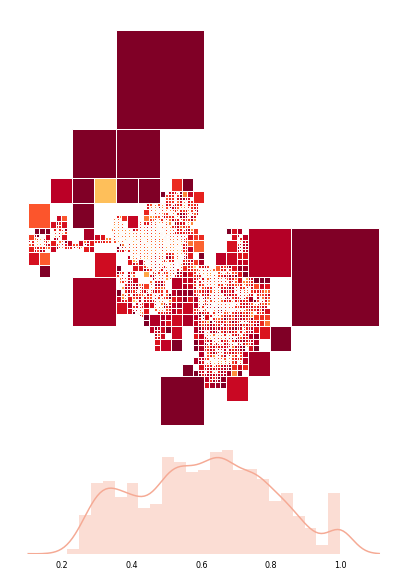

In [10]:
msno.geoplot(loc_data.sample(100000), x='Location_X', y='Location_Y', histogram="True")

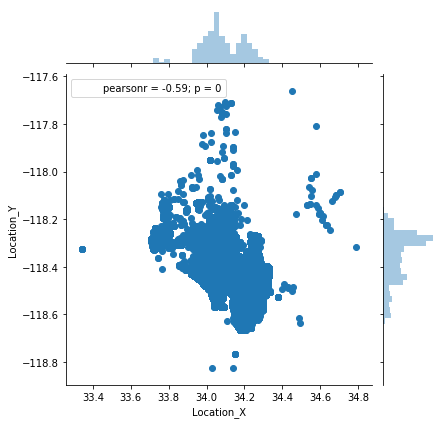

In [43]:
sns.jointplot(x='Location_X', y='Location_Y', data=loc_data)
plt.show()

Note this graphing takes a long time, therefore the sampling.

## Types of Crimes

In [7]:
master_data['Crime Code Description'].unique()

array(['INTIMATE PARTNER - SIMPLE ASSAULT', 'VEHICLE - STOLEN',
       'VANDALISM - MISDEAMEANOR ($399 OR UNDER)', 'CRIMINAL HOMICIDE',
       'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
       'THEFT PLAIN - PETTY ($950 & UNDER)', 'STALKING',
       'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
       'BATTERY - SIMPLE ASSAULT',
       'EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)',
       'DOCUMENT FORGERY / STOLEN FELONY', 'BIKE - STOLEN', 'ROBBERY',
       'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH 0007=02',
       'ATTEMPTED ROBBERY', 'RESISTING ARREST', 'TRESPASSING',
       'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD0036',
       'COUNTERFEIT', 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
       'THROWING OBJECT AT MOVING VEHICLE',
       'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $400 & UNDER',
       'CRIMINAL THREATS - NO WEAPON DISPLAYED',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) 0114',
       'BURGLARY FROM VEHICLE', 'BATTER

Here we have all the different types of crimes occurred. Lets see what the most common types are.

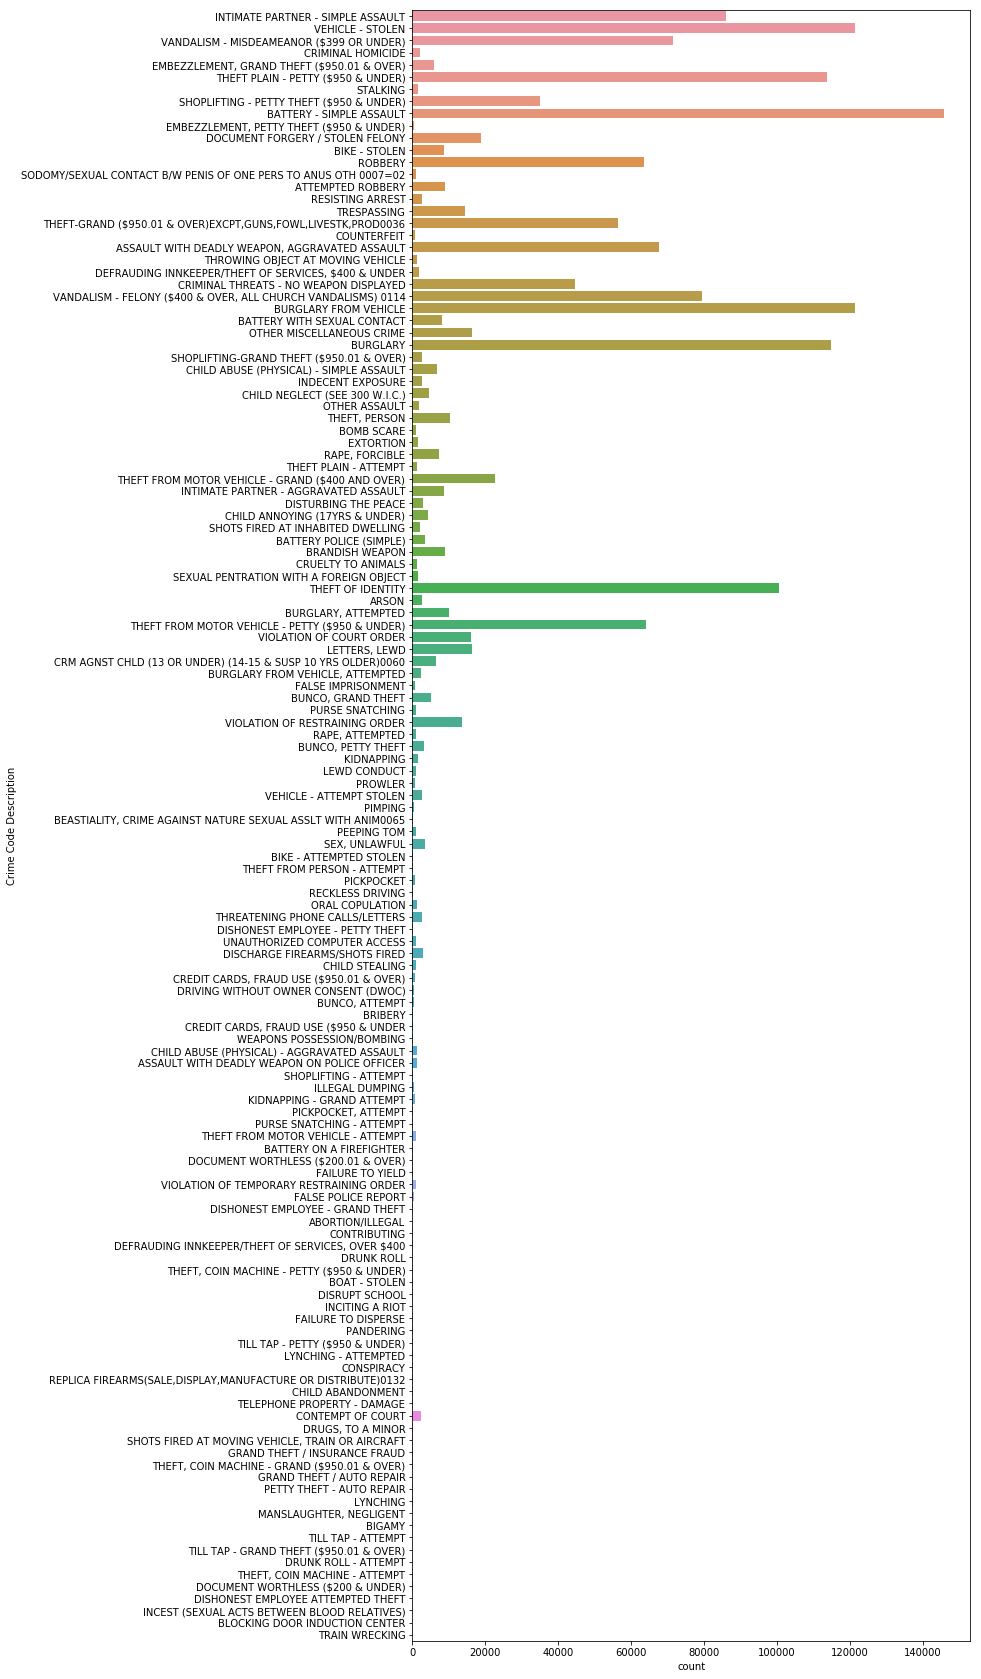

In [25]:
plt.figure(figsize=(10,30))
count = sns.countplot(
    data = master_data, 
    y = 'Crime Code Description',
)
plt.show()

### Observation
Here we see that the two most common type of crime is assault, and stealing vehicles and objects from vehicles are also popular. 

I am going to look at crimes related to vehicles a little more closely now, as I have intuition that these crimes might be premeditated and therefore possible to predict.

## Vehicle Crimes

1. Graphing
2. Seasonality
3. Prediction

In [10]:
vehicle_codes = ['VEHICLE - STOLEN', 
                 'BURGLARY FROM VEHICLE', 
                 'THEFT FROM MOTOR VEHICLE - ATTEMPT', 
                 'BURGLARY FROM VEHICLE, ATTEMPTED',
                 'VEHICLE - ATTEMPT STOLEN',
                 'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
                 'THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)'
                 
                ]
vehicle_data = master_data.loc[master_data['Crime Code Description'].isin(vehicle_codes)]
vehicle_data_loc = vehicle_data.loc[master_data['Location_X'] != 0]

Something odd to notice, is the last two codes are contradictory-- as if a theft could be grand and petty.

### Graphing

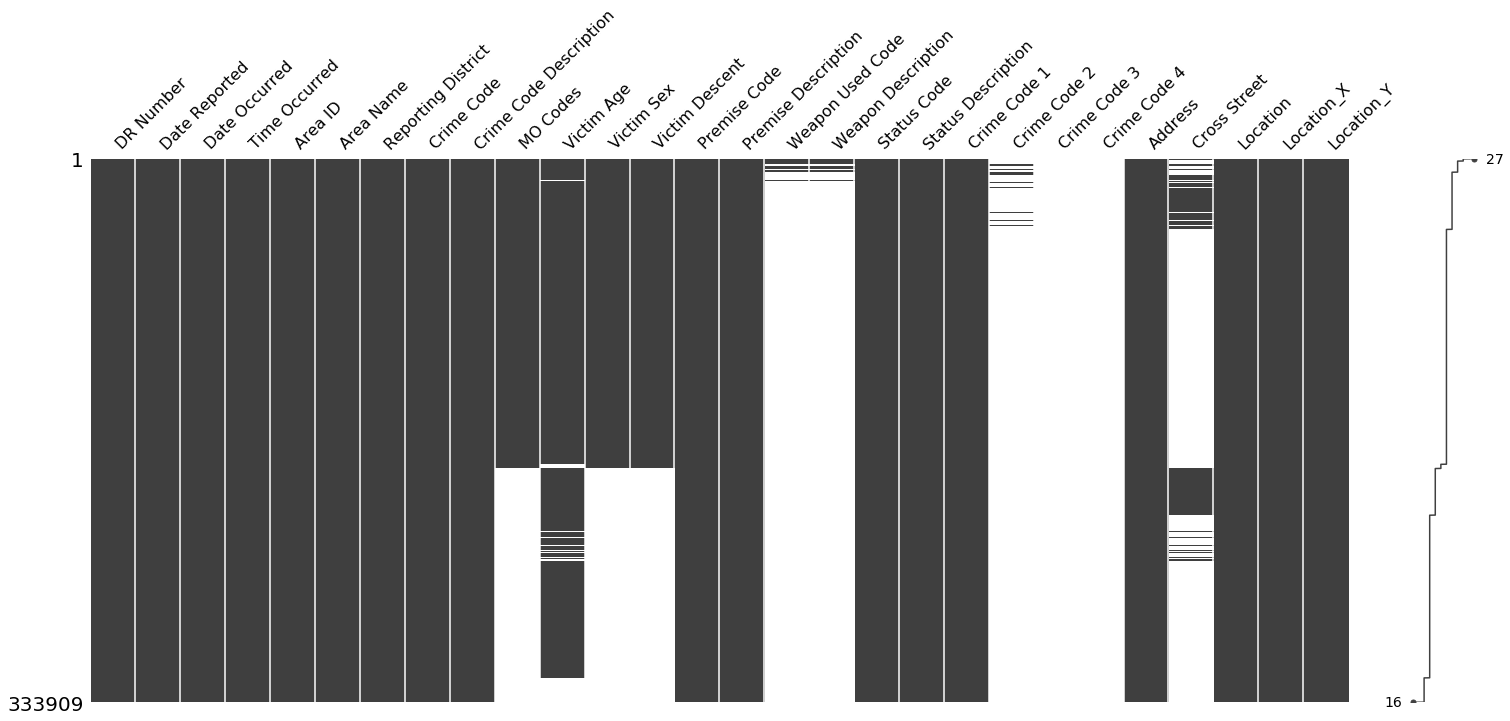

In [10]:
sorted_data_V = msno.nullity_sort(vehicle_data_loc, sort='descending')
msno.matrix(sorted_data_V)

In [11]:
vehicle_data = vehicle_data.drop(
    labels=['Weapon Used Code', 
            'Weapon Description', 
            'Crime Code 2', 
            'Crime Code 3', 
            'Crime Code 4', 
            'Cross Street'],
    axis=1)

For now we are only going to worry about lat/long, so I will remove the cross streeet feature. Also weapon data will be ignored as well as crime code 2/3, as we are only looking at vehicle data.

How does the number of crimes change throughout the year? Maybe cold(ish) weather or the holidays prompts people to do other things

In [12]:
vehicle_data['Month Occurred'] = vehicle_data['Date Occurred'].dt.month
vehicle_data['Day of Week Occurred'] = vehicle_data['Date Occurred'].dt.dayofweek
vehicle_data['Year Occurred'] = vehicle_data['Date Occurred'].dt.year
vehicle_data['Month and Year Occurred'] = list(zip(vehicle_data['Year Occurred'], vehicle_data['Month Occurred']))

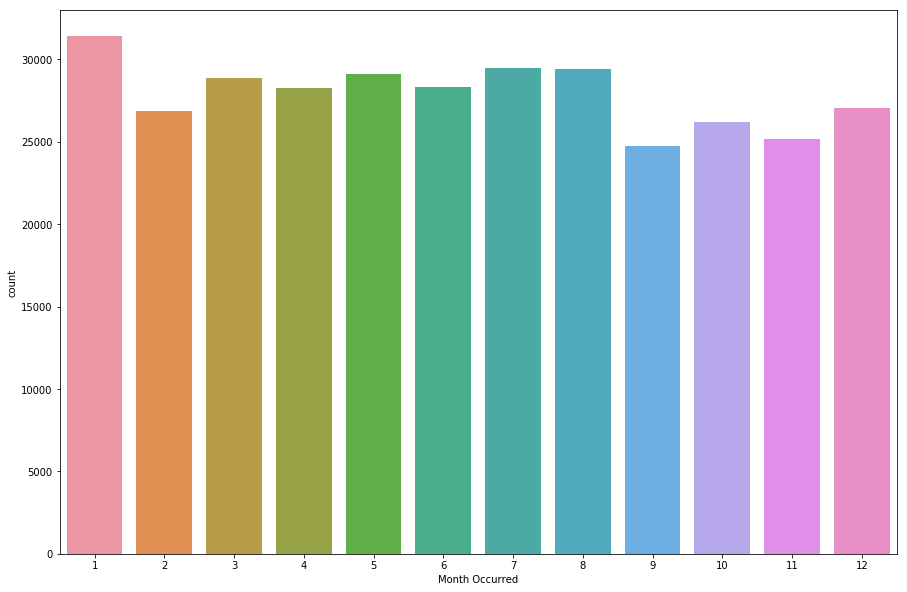

In [32]:
plt.figure(figsize=(15,10))
sns.countplot(x = 'Month Occurred', data = vehicle_data)
plt.show()

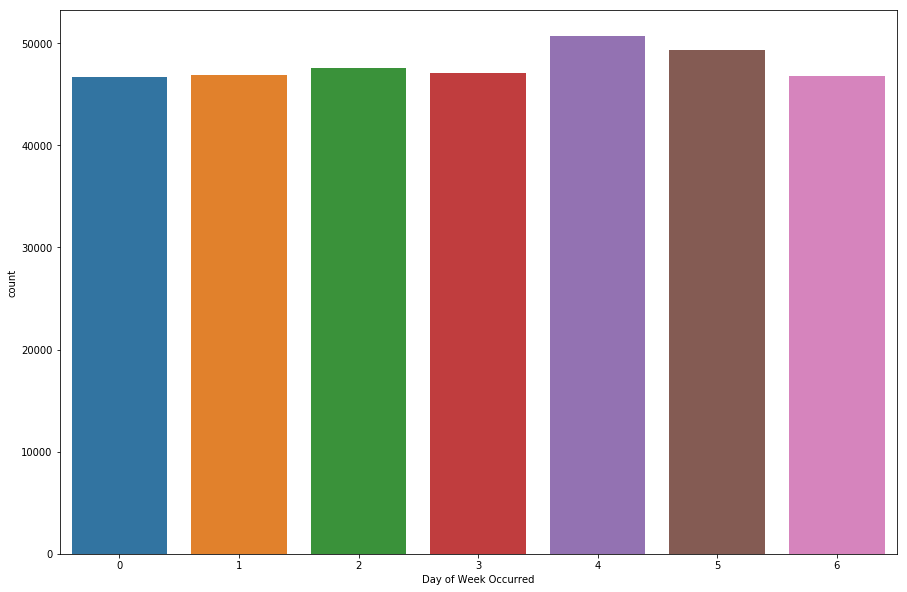

In [33]:
plt.figure(figsize=(15,10))
sns.countplot(x = 'Day of Week Occurred', data = vehicle_data)
plt.show()

### Observation
So it looks as if Fridays and January are the popular times to commit vehicle related crimes. Friday seems self explanatory, and January maybe is a reaction to the lack of thefts in November / December. It doesn't seem that it being winter has a large effect however, which makes sense as it is still pleasant outside in LA that time of year.

Let us take a look at how this changes over the year, by grouping our data by month and year.

In [13]:
vehicle_data_TSM = vehicle_data.groupby('Month and Year Occurred').count()['DR Number']

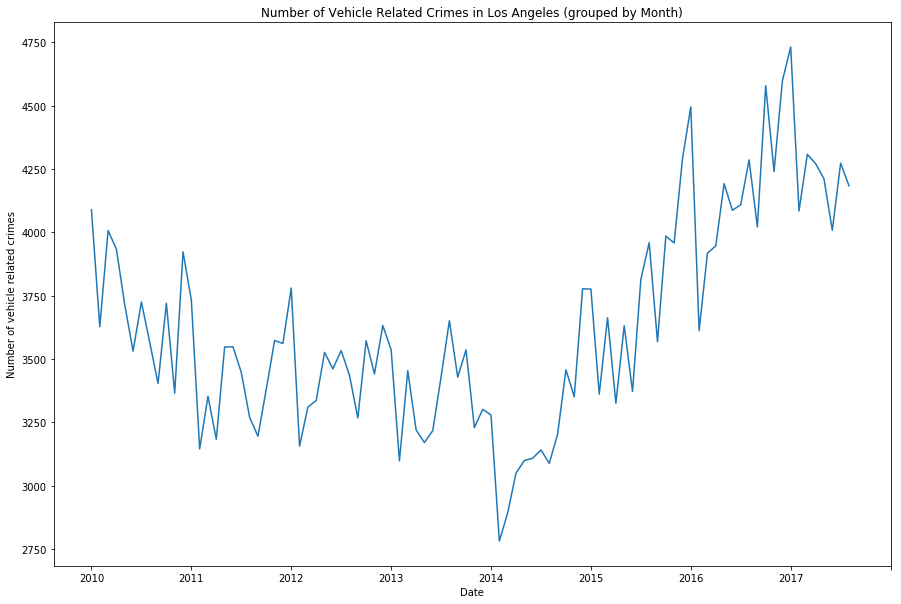

In [14]:
# ignoring last value as it is an outlier
plt.figure(figsize=(15,10))
plt.plot(vehicle_data_TSM.values[:-1])
plt.xticks([i * 12 for i in range(9)], ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'))
plt.xlabel('Date')
plt.ylabel('Number of vehicle related crimes')
plt.title('Number of Vehicle Related Crimes in Los Angeles (grouped by Month)')
plt.show()

In [15]:
vehicle_data_TSD = vehicle_data.groupby('Date Occurred').count()['DR Number']

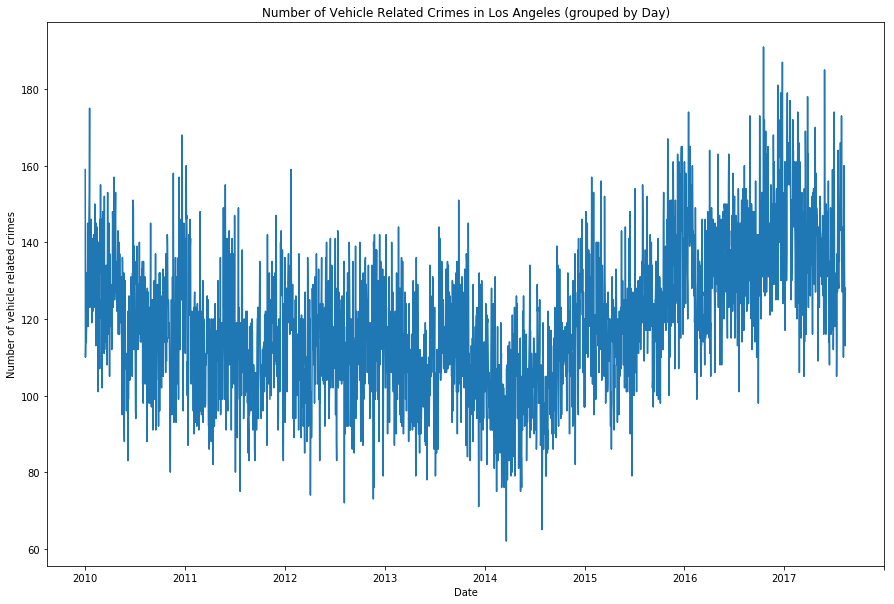

In [16]:
# Removed last 30 days as they may be outliers-- ie not yet reported
plt.figure(figsize=(15,10))
plt.plot(vehicle_data_TSD.values[:-30])
plt.xticks([i * 365 for i in range(9)], ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'))
plt.xlabel('Date')
plt.ylabel('Number of vehicle related crimes')
plt.title('Number of Vehicle Related Crimes in Los Angeles (grouped by Day)')
plt.show()

### Observation
Pretty significant dip in Feb 2014. Quick google search of national news at that time this is the only thing that might be related.. probably not but fun to speculate.
https://www.nytimes.com/2014/02/23/world/americas/joaquin-guzman-loera-sinaloa-drug-cartel-leader-is-captured-in-mexico.html?_r=0

Now, instead of speculating perhaps we can see if there statistically significant seasonality going on here.

## Seasonality
We will use autocorrelation plot first to see if there is any seasonality in this data. First though I am going to split this data into training/testing sets. For the time being I am only going to worry about what was just graphed, the number of crimes occurring on any given day

In [17]:
# Testing and training split
trainV_TSM = vehicle_data_TSM[:int(.8 * len(vehicle_data_TSM))]
testV_TSM = vehicle_data_TSM[int(.8 * len(vehicle_data_TSM)):]
trainV_TSD = vehicle_data_TSD[:int(.8 * len(vehicle_data_TSD))]
trainV_TSD = vehicle_data_TSD[int(.8 * len(vehicle_data_TSD)):]

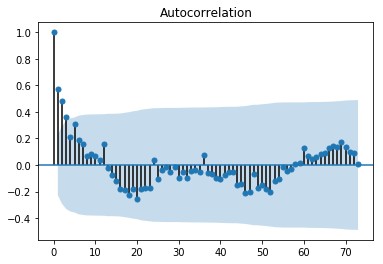

In [18]:
plot_acf(trainV_TSM)
plt.show()

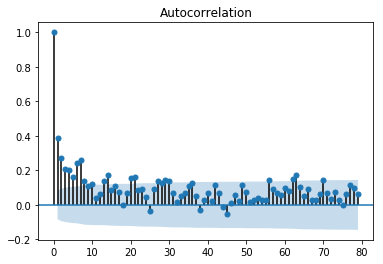

In [19]:
plot_acf(trainV_TSD, lags=np.arange(80))
plt.show()

### Observation
So it looks like there is not a lot of seasonality in the monthly data. It can be seen that at n=12 (1 year) there ia a small spike, but this is not outside the statistically insignificant range. The daily data has many more lags that are statistically significant. This is probably because we are retaining days of week in our data here. For example, it will be clear if we look at 10 days worth of lags..

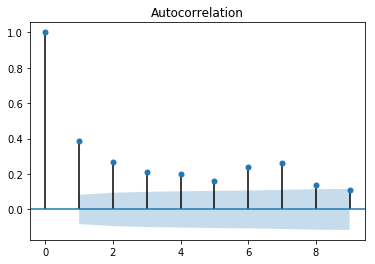

In [20]:
plot_acf(trainV_TSD, lags=np.arange(10))
plt.show()

We have a bump at 7. So it is weekly-seasonal. However it should be noticed that many of these lags are significant, therefore we should look at partial autocorrelation. What partial autocorrelation does is take out the intermediary lags, so if we are looking at say a lag of 8 we arent also looking at two lags of 4.

I will continue by looking at the daily data, as this is what I intend on predicting soon.

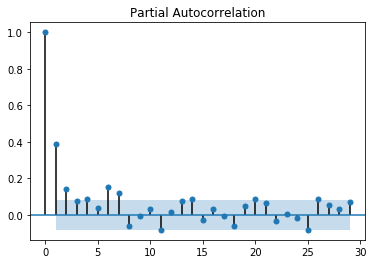

In [21]:
plot_pacf(trainV_TSD, lags=np.arange(30))
plt.show()

### Observation
Great, so out data is seasonal. Let's make a quick ARIMA model to forecast this timeseries. This is not our goal overall, but nevertheless interesting to see how well we can do.

First we can difference the data to make it stationary, as the ARIMA model requires this value.

## Prediction

In [22]:
adf = adfuller(trainV_TSD.diff(1)[1:])
print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])
print('Critical Values', adf[4]['1%'])

ADF Statistic: -5.317584
p-value: 0.000005
('Critical Values', -3.442495284887805)


Cool! Very stationary. Quick Graph to see this visually.

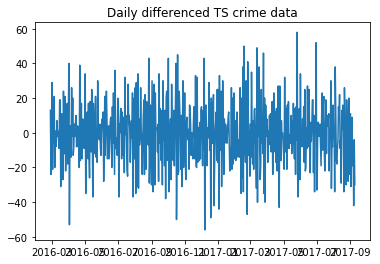

In [23]:
plt.plot(trainV_TSD.diff(1)[1:])
plt.title('Daily differenced TS crime data')
plt.show()

Now lets use this ARIMA model to try and predict

In [24]:
# fit model, converting to float to address bug found here https://github.com/statsmodels/statsmodels/issues/3504
trainV_TSD = trainV_TSD.astype(float)
model = ARIMA(trainV_TSD, order=(7,1,0))
model.fit(method='css')

In [40]:
plt.plot(model.predict(start=0, end=100, dynamic = True))

TypeError: predict() takes at least 2 arguments (4 given)

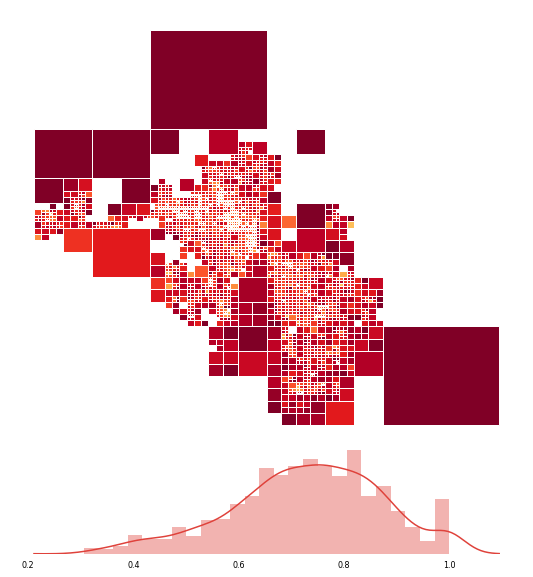

In [38]:
msno.geoplot(vehicle_data_loc.sample(50000), x='Location_X', y='Location_Y', histogram="True")

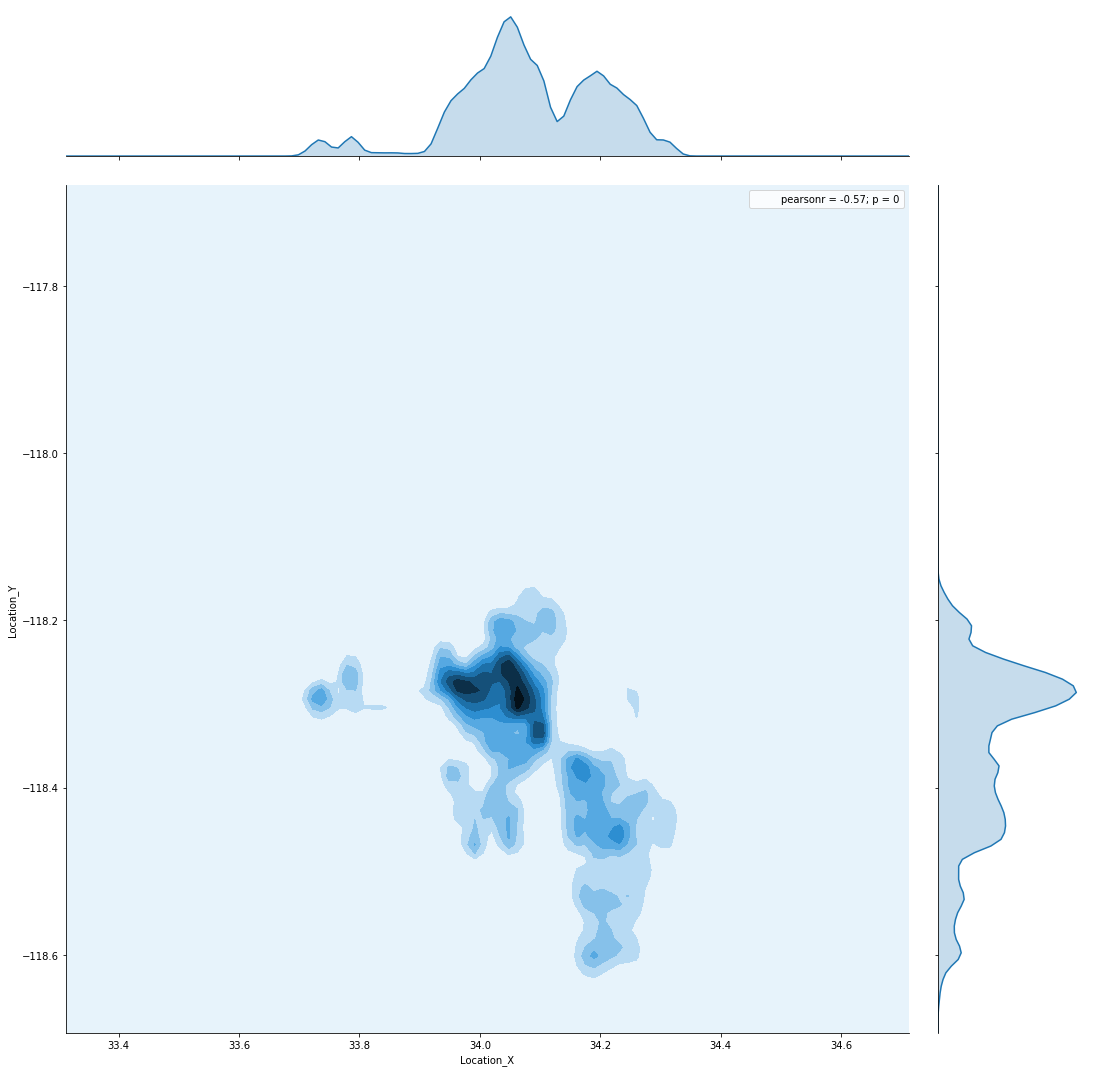

In [18]:
sns.jointplot(
    x='Location_X', 
    y='Location_Y', 
    data=vehicle_data_loc, 
    size=15, 
    kind='kde')

In [25]:
master_data['Date Occurred'] = pd.to_datetime(master_data['Date Occurred'])

Here we see there are a few geographical areas where vehicle related crimes are commonplace.

Here we are looking the geographical location of these crimes for the past few years, curious to investigate whether there has been a moving trend over the years.

In [99]:
vehicle_data_date = vehicle_data.sort_values('Date Occurred')

Looks as is we may have a pattern here, also some gaps however which are perhaps missing values

In [55]:
vehicle_data['Date Occurred'] = pd.to_datetime(vehicle_data['Date Occurred'])

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [76]:
vehicle_data['Day of Week Occurred'] = vehicle_data['Date Occurred'].dt.dayofweek

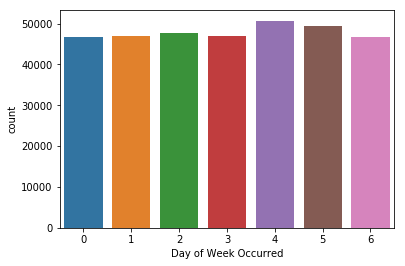

In [77]:
sns.countplot(x = 'Day of Week Occurred', data = vehicle_data)

In [100]:
vehicle_data['Day of Year Occurred'] = vehicle_data['Date Occurred'].dt.dayofyear

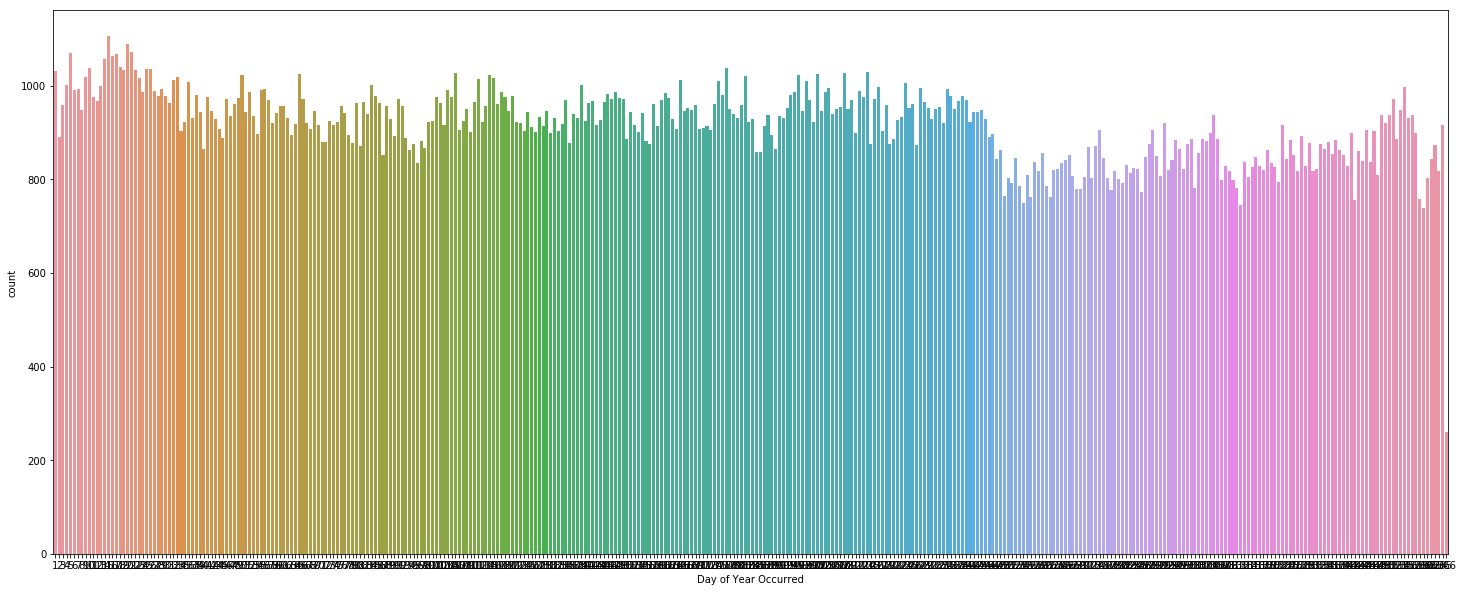

In [82]:
plt.figure(figsize=(25,10))
yearGraph = sns.countplot(x = 'Day of Year Occurred', data = vehicle_data)

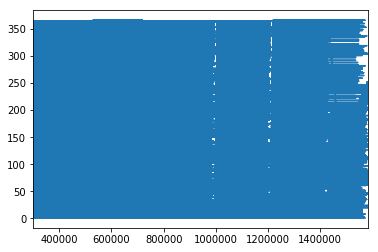

In [110]:
vehicle_data['Day of Year Occurred'].plot()